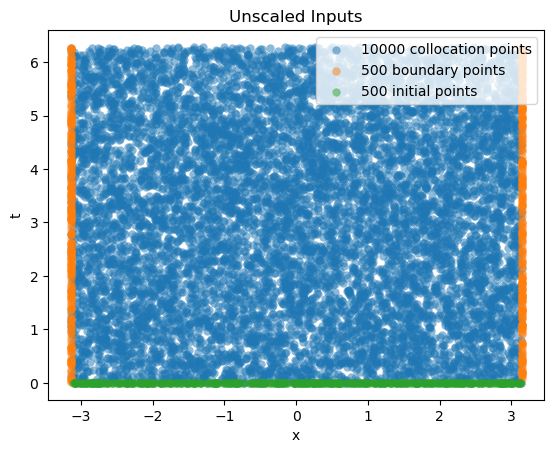

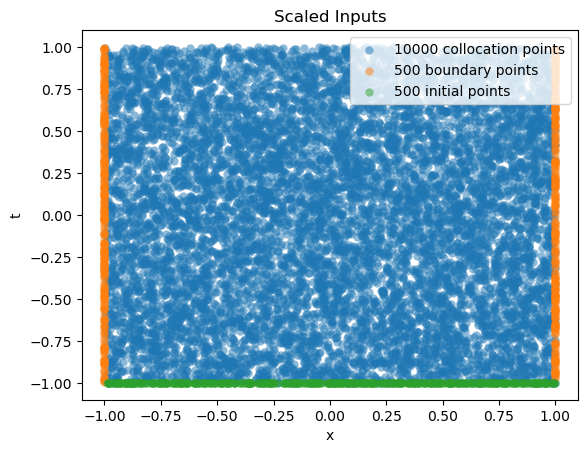

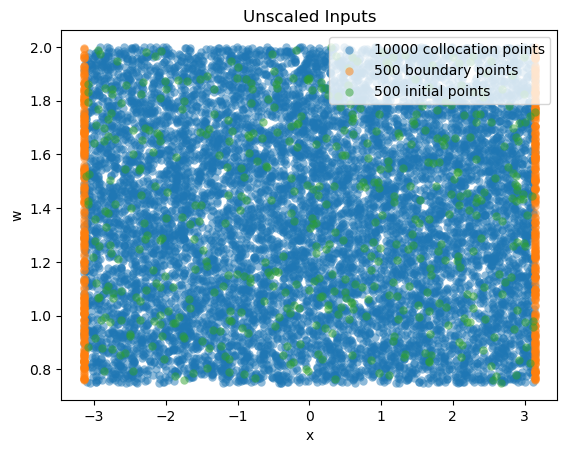

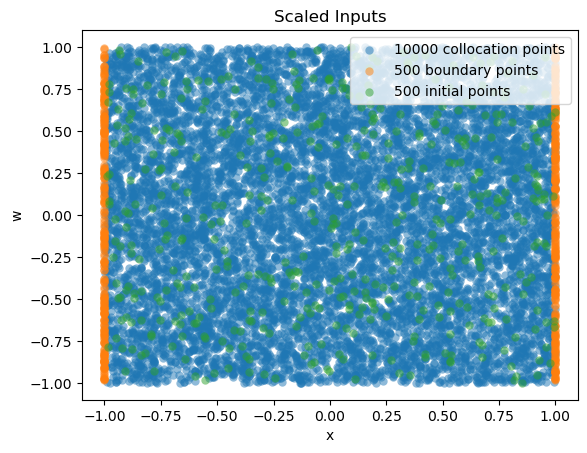

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# renormalization
@tf.function
def normalization(input_min, input_max, N, psi_Re, psi_Im):
    dx = (input_max - input_min) / N
    norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
    return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 500, 500

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
w_f = tf.random.uniform((N_f, 1), w_min, w_max, dtype=DTYPE)
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled
w_fs = scale_inputs(w_f, w_min, w_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
w_b = tf.random.uniform((N_b, 1), w_min, w_max, dtype=DTYPE)
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled
w_bs = scale_inputs(w_b, w_min, w_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)
w_i = tf.random.uniform((N_i, 1), w_min, w_max, dtype=DTYPE)
psi_i = tf.cast(psi_init(x_i, w_i, pi), tf.complex128)
# psi_i_Re, psi_i_Im = normalization(x_min, x_max, N_i, tf.math.real(psi_i), tf.math.imag(psi_i))
x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled
w_is = scale_inputs(w_i, w_min, w_max)  # scaled

# plotting collocation, boundary, and initial points
plt.scatter(x_f, t_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_b, t_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_i, t_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Unscaled Inputs')
plt.legend(loc='upper right')
plt.show()

plt.scatter(x_fs, t_fs, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_bs, t_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, t_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

plt.scatter(x_f, w_f, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_b, w_b, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_i, w_i, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('w')
plt.title('Unscaled Inputs')
plt.legend(loc='upper right')
plt.show()

plt.scatter(x_fs, w_fs, alpha=0.5, linewidths=1e-6, label=f'{N_f} collocation points')
plt.scatter(x_bs, w_bs, alpha=0.5, linewidths=1e-6, label=f'{N_b} boundary points')
plt.scatter(x_is, w_is, alpha=0.5, linewidths=1e-6, label=f'{N_i} initial points')
plt.xlabel('x')
plt.ylabel('w')
plt.title('Scaled Inputs')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=3, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [3]:
# We use Hartree atomic units \hbar = m = 1
# Define the Physics Loss
@tf.function
def pde_residual(model, x, t, w):
    with tf.GradientTape(persistent=True) as tape2:
        tape2.watch([x, t])
        with tf.GradientTape(persistent=True) as tape1:
            tape1.watch([x, t])
            X = tf.concat([x, t, w], axis=1)
            uv = model(X)
            u, v = uv[:, 0:1], uv[:, 1:2]
        u_x = tape1.gradient(u, x)
        v_x = tape1.gradient(v, x)
        u_t = tape1.gradient(u, t)
        v_t = tape1.gradient(v, t)
    u_xx = tape2.gradient(u_x, x)
    v_xx = tape2.gradient(v_x, x)
    del tape1, tape2

    potential = 0.5 * w**2 * x**2

    f_u = -v_t + 0.5*u_xx - potential*u
    f_v = u_t + 0.5*v_xx - potential*v

    return f_u, f_v

@tf.function
def loss_fn(model, interior, boundary, initial, omega):
    x_f, t_f = interior
    x_b, t_b = boundary
    x_i, t_i, psi_i = initial
    w_f, w_b, w_i = omega

    f_u, f_v = pde_residual(model, x_f, t_f, w_f)
    loss_f = tf.reduce_mean(tf.square(f_u) + tf.square(f_v))

    uv_b = model(tf.concat([x_b, t_b, w_b], axis=1))
    loss_b = tf.reduce_mean(tf.square(uv_b[:, 0:1]) + tf.square(uv_b[:, 1:2]))

    uv_i = model(tf.concat([x_i, t_i, w_i], axis=1))
    loss_i = tf.reduce_mean(tf.square(uv_i[:, 0:1] - tf.math.real(psi_i)) +
                            tf.square(uv_i[:, 1:2] - tf.math.imag(psi_i)))
    
    return loss_f + 10.0*loss_b + 100.0*loss_i, (loss_f, 10.0*loss_b, 100.0*loss_i)

# # Create the model
# model = PINN(input_dim=3, mapping_size=512, scale=10.0)

# # Save the model in Keras format
# model_test_path = 'model_test_v0.keras'
# model.save(model_test_path)
# print(f"Model saved to {model_test_path}")

# # Load the model
# loaded_model = tf.keras.models.load_model(model_test_path, custom_objects={'PINN': PINN})

# # Dummy input to build the model (batch size 1, input_dim = 2)
# dummy_input = tf.concat([x_f[:5], t_f[:5], w_f[:5]], axis=1)
# _ = loaded_model(dummy_input)

# loaded_model.summary()

In [ ]:
# Define the Optimizer
# Learning rate schedule with exponential decay
initial_learning_rate = 0.001
decay_rate = 0.6
decay_steps = 1000

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True
)

# ADAM optimizer with beta1 = 0.09, beta2 = 0.999 (unusual but from paper)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    clipnorm=1.0
)

# Training Step Function
@tf.function
def train_step(model, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, w_f, w_b, w_i):
    with tf.GradientTape() as tape:
        loss, (lf, lb, li) = loss_fn(model, (x_f, t_f), (x_b, t_b), (x_i, t_i, psi_i), (w_f, w_b, w_i))
        
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, (lf, lb, li)

Epoch 0: Loss = 6.14757e+03 (f = 6.079e+03, b = 5.379e+00, i = 6.292e+01)


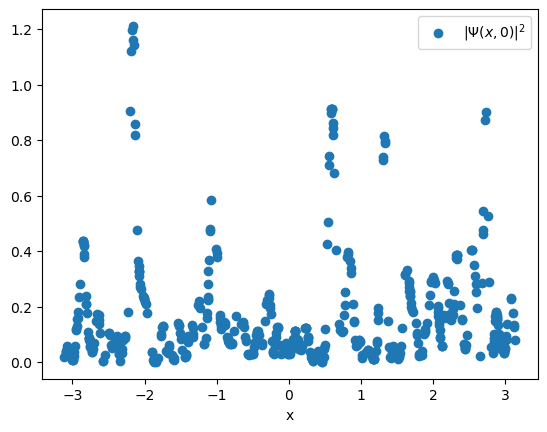

Best model saved to best_model_v0.keras at epoch 0
Best model saved to best_model_v0.keras at epoch 2
Best model saved to best_model_v0.keras at epoch 3
Best model saved to best_model_v0.keras at epoch 4
Best model saved to best_model_v0.keras at epoch 5
Best model saved to best_model_v0.keras at epoch 6
Best model saved to best_model_v0.keras at epoch 7
Best model saved to best_model_v0.keras at epoch 8
Best model saved to best_model_v0.keras at epoch 9
Best model saved to best_model_v0.keras at epoch 10
Best model saved to best_model_v0.keras at epoch 11
Best model saved to best_model_v0.keras at epoch 12
Best model saved to best_model_v0.keras at epoch 13
Best model saved to best_model_v0.keras at epoch 14
Best model saved to best_model_v0.keras at epoch 15
Best model saved to best_model_v0.keras at epoch 16
Best model saved to best_model_v0.keras at epoch 17
Best model saved to best_model_v0.keras at epoch 18
Best model saved to best_model_v0.keras at epoch 19
Best model saved to b

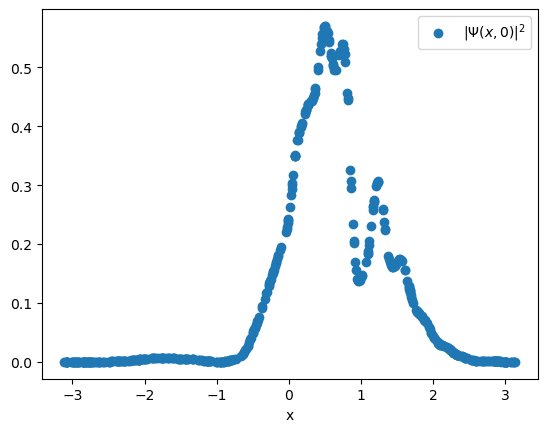

Best model saved to best_model_v0.keras at epoch 1003
Best model saved to best_model_v0.keras at epoch 1041
Best model saved to best_model_v0.keras at epoch 1105
Best model saved to best_model_v0.keras at epoch 1259
Best model saved to best_model_v0.keras at epoch 1427
Best model saved to best_model_v0.keras at epoch 1515
Best model saved to best_model_v0.keras at epoch 1613
Best model saved to best_model_v0.keras at epoch 1617
Best model saved to best_model_v0.keras at epoch 1619
Best model saved to best_model_v0.keras at epoch 1735
Epoch 2000: Loss = 8.08240e-03 (f = 2.350e-03, b = 8.495e-05, i = 5.647e-03)


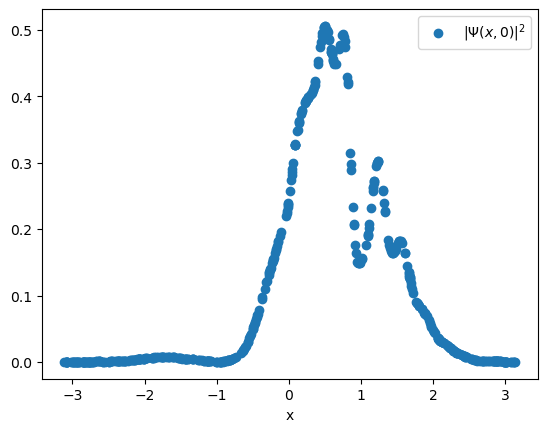

Best model saved to best_model_v0.keras at epoch 2038
Best model saved to best_model_v0.keras at epoch 2039
Best model saved to best_model_v0.keras at epoch 2058
Best model saved to best_model_v0.keras at epoch 2059
Best model saved to best_model_v0.keras at epoch 2069
Best model saved to best_model_v0.keras at epoch 2070
Best model saved to best_model_v0.keras at epoch 2203
Best model saved to best_model_v0.keras at epoch 2204
Best model saved to best_model_v0.keras at epoch 2220
Best model saved to best_model_v0.keras at epoch 2237
Best model saved to best_model_v0.keras at epoch 2238
Best model saved to best_model_v0.keras at epoch 2242
Best model saved to best_model_v0.keras at epoch 2243
Best model saved to best_model_v0.keras at epoch 2244
Best model saved to best_model_v0.keras at epoch 2245
Best model saved to best_model_v0.keras at epoch 2246
Best model saved to best_model_v0.keras at epoch 2247
Best model saved to best_model_v0.keras at epoch 2248
Best model saved to best_mod

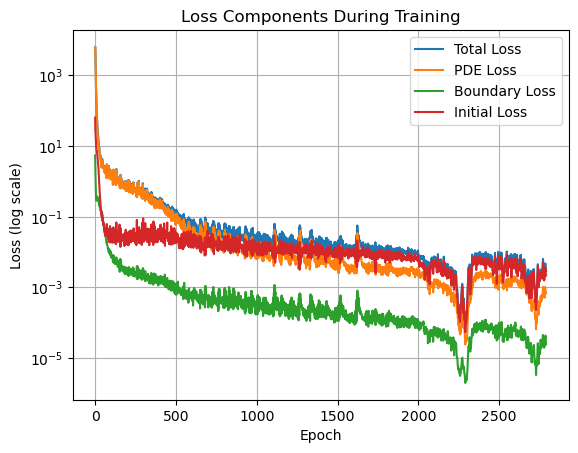


Weights match.
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!
Weights do not match after loading!


In [5]:
# Instantiate the Model
pinn = PINN(input_dim=3, mapping_size=512, scale=10.0)

# Define the loss threshold
loss_threshold = 1e-10

# Early stopping
early_stopping_patience = 500
best_loss = float('inf')
patience_counter = 0

# saving loss values
train_loss_results = {
    "total": [],
    "pde": [],
    "boundary": [],
    "initial": []
}

# Start the timer
start_time = time.time()

best_model_path = "best_model_v0.keras"

# Training Loop until loss < loss_threshold
epoch = 0
while True:
    loss, (lf, lb, li) = train_step(pinn, x_f, t_f, x_b, t_b, x_i, t_i, psi_i, w_f, w_b, w_i)

    train_loss_results["total"].append(loss.numpy())
    train_loss_results["pde"].append(lf.numpy())
    train_loss_results["boundary"].append(lb.numpy())
    train_loss_results["initial"].append(li.numpy())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy().item():.5e} (f = {lf.numpy().item():.3e}, b = {lb.numpy().item():.3e}, i = {li.numpy().item():.3e})")

        w_sample = tf.ones_like(x_i)
        X = tf.concat([x_i, t_i, w_sample], axis=1)
        uv = pinn(X)
        u, v = uv[:, 0:1], uv[:, 1:2]
        density = u**2 + v**2

        plt.scatter(x_i, density, label=r'$|\Psi(x,0)|^2$')
        plt.xlabel('x')
        plt.legend()
        plt.show()
        
    if loss.numpy() < best_loss:
        best_loss = loss.numpy()
        patience_counter = 0
        pinn.save(best_model_path)
        print(f"Best model saved to {best_model_path} at epoch {epoch}")
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch} as loss did not improve for {early_stopping_patience} epochs.")
        print(f"Training stopped at epoch {epoch} with loss {loss.numpy()}")
        break
    
    if loss.numpy() < loss_threshold:
        print(f"Training stopped at epoch {epoch} as loss reached {loss.numpy()}")
        break

    epoch += 1

# End the timer
end_time = time.time()

# Calculate total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, seconds
execution_time_formatted = str(datetime.timedelta(seconds=int(execution_time)))

print(f"Total training time: {execution_time_formatted}")
        
# Plot the Loss vs. Epochs
plt.plot(train_loss_results["total"], label="Total Loss")
plt.plot(train_loss_results["pde"], label="PDE Loss")
plt.plot(train_loss_results["boundary"], label="Boundary Loss")
plt.plot(train_loss_results["initial"], label="Initial Loss")
plt.yscale("log")
plt.legend()
plt.title("Loss Components During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

# Save original weights
original_weights = pinn.get_weights()

# Load the model
loaded_pinn = tf.keras.models.load_model(best_model_path, custom_objects={'PINN': PINN})

# Check if the weights match
loaded_weights = loaded_pinn.get_weights()

for orig, loaded in zip(original_weights, loaded_weights):
    if not np.array_equal(orig, loaded):
        print("Weights do not match after loading!")
    else:
        print("Weights match.")

Normalization check for the initial condition: $|\Psi(x,0)|**2=1.0$
Model loaded successfully


Model: "pinn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ fourier_feature_layer_6         │ ?                      │         1,536 │
│ (FourierFeatureLayer)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (10000, 512)           │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (10000, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (10000, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (10000, 512)           │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (10000, 2)             │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,315,330 (10.04 MB)

 Trainable params: 1,313,794 (10.02 MB)

 Non-trainable params: 1,536 (12.00 KB)

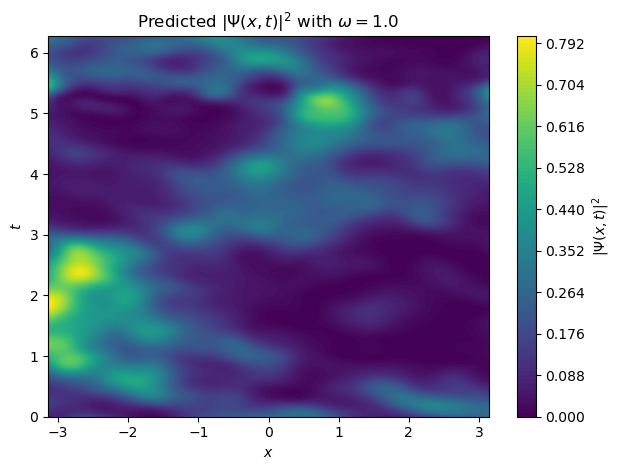

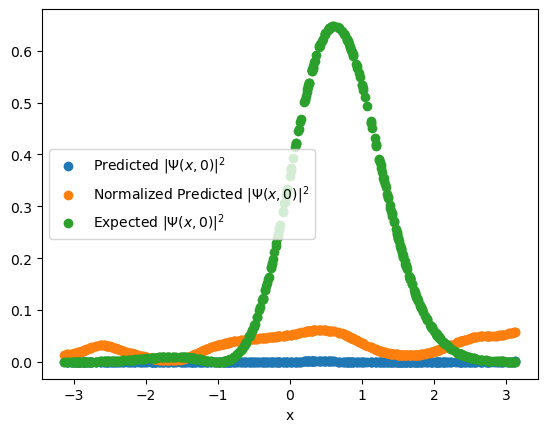

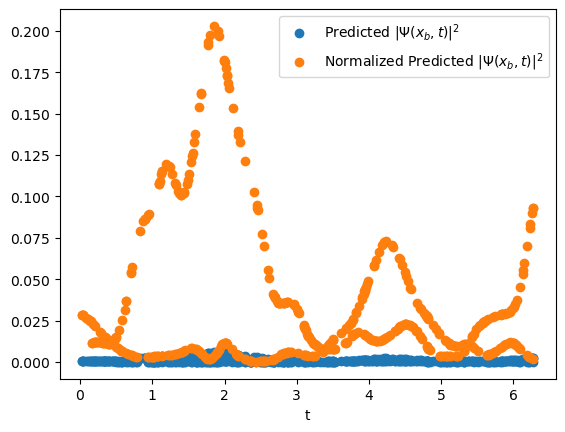

In [ ]:
############################## Loading the model ##############################

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime

# use float64 for higher precision in PDEs
tf.keras.backend.set_floatx('float64')
DTYPE = tf.float64

# declare inputs
w_min, w_max = tf.constant(0.75, dtype=DTYPE), tf.constant(2.0, dtype=DTYPE)
pi = tf.constant(np.pi, dtype=DTYPE)
x_min, x_max = -pi, pi
t_min, t_max = tf.constant(0.0, dtype=DTYPE), 2.0*pi

# scale inputs
@tf.function
def scale_inputs(input, input_min, input_max):
    return 2.0 * (input - input_min) / (input_max - input_min) - 1.0

# renormalization
@tf.function
def normalization(input_min, input_max, N, psi_Re, psi_Im):
    dx = (input_max - input_min) / N
    norm = tf.math.sqrt(tf.reduce_sum(psi_Re**2 + psi_Im**2) * dx)
    return (psi_Re/norm), (psi_Im/norm)

# initial condition
@tf.function
def psi_init(x, w, pi):
    u_0 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2)
    u_1 = (w/pi)**0.25 * tf.math.exp(-0.5*w*x**2) * x * tf.math.sqrt(w)
    return (1.0/np.sqrt(2.0)) * (u_0 + u_1)

# data generation
N_f, N_b, N_i = 10000, 5000, 5000
w_test = 1.0

# interior points
x_f = tf.random.uniform((N_f, 1), x_min, x_max, dtype=DTYPE)
t_f = tf.random.uniform((N_f, 1), t_min, t_max, dtype=DTYPE)
x_fs = scale_inputs(x_f, x_min, x_max)  # scaled
t_fs = scale_inputs(t_f, t_min, t_max)  # scaled

# boundary points
x_b = tf.concat([tf.ones((N_b//2, 1), dtype=DTYPE) * x_min,
                 tf.ones((N_b//2, 1), dtype=DTYPE) * x_max], axis=0)
t_b = tf.random.uniform((N_b, 1), t_min, t_max, dtype=DTYPE)
w_b = tf.ones_like(x_b) * w_test
x_bs = scale_inputs(x_b, x_min, x_max)  # scaled
t_bs = scale_inputs(t_b, t_min, t_max)  # scaled
w_bs = scale_inputs(w_b, w_min, w_max)  # scaled

# initial points
x_i = tf.random.uniform((N_i, 1), x_min, x_max, dtype=DTYPE)
t_i = tf.zeros_like(x_i, dtype=DTYPE)

w_i = tf.ones_like(x_i) * w_test
psi_i = tf.cast(psi_init(x_i, w_i, pi), tf.complex128)
psi_i_Re, psi_i_Im = normalization(x_min, x_max, N_i, tf.math.real(psi_i), tf.math.imag(psi_i))
x_is = scale_inputs(x_i, x_min, x_max)  # scaled
t_is = scale_inputs(t_i, t_min, t_max)  # scaled
w_is = scale_inputs(w_i, w_min, w_max)  # scaled

# verify normalization
dx_i = (x_max - x_min) / N_i
norm_check = tf.reduce_sum(psi_i_Re**2 + psi_i_Im) * dx_i
print(f'Normalization check for the initial condition: $|\Psi(x,0)|**2={norm_check}$')

# Fourier feature layer
@tf.keras.utils.register_keras_serializable()
class FourierFeatureLayer(tf.keras.layers.Layer):
    def __init__(self, input_dim, mapping_size=512, scale=10.0, **kwargs):
        super(FourierFeatureLayer, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

    def build(self, input_shape):
        self.B = self.add_weight(name="B",
                                 shape=[self.input_dim, self.mapping_size],
                                 initializer=tf.random_normal_initializer(stddev=self.scale),
                                 trainable=False)
    
    def call(self, x):
        x_proj = tf.matmul(x, self.B)
        return tf.concat([tf.math.sin(x_proj), tf.math.cos(x_proj)], axis=-1)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config
    
# Define the Neural Network
@tf.keras.utils.register_keras_serializable()
class PINN(tf.keras.Model):
    def __init__(self, input_dim=3, mapping_size=512, scale=10.0, **kwargs):
        super(PINN, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.scale = scale

        self.fourier = FourierFeatureLayer(input_dim=input_dim, mapping_size=mapping_size, scale=scale)
        initializer = tf.keras.initializers.GlorotNormal()

        self.dense1 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense2 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense3 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.dense4 = tf.keras.layers.Dense(512, activation='tanh', kernel_initializer=initializer)
        self.out = tf.keras.layers.Dense(2, activation='linear', kernel_initializer=initializer) # u_Re, u_Im
        
    def call(self, x):
        x = self.fourier(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        return self.out(x)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim": self.input_dim,
            "mapping_size": self.mapping_size,
            "scale": self.scale
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
# Load the model
loaded_model = tf.keras.models.load_model('best_model_v0.keras', custom_objects={'PINN': PINN})
print("Model loaded successfully")

loaded_model.summary()

################## Plot: Contour Plot ###############################

# Contour Plot
N = 100
x_plot = np.linspace(x_min, x_max, N)[:,None]
t_plot = np.linspace(t_min, t_max, N)[:,None]
x_plot_scaled = scale_inputs(x_plot, x_min, x_max)
t_plot_scaled = scale_inputs(t_plot, t_min, t_max)
X_grid, T_grid = np.meshgrid(x_plot, t_plot)  # t and x grid

x_plot_in = tf.convert_to_tensor(x_plot_scaled, dtype=DTYPE)
t_plot_in = tf.convert_to_tensor(t_plot_scaled, dtype=DTYPE)
w_plot = tf.ones_like(x_plot_in) * w_test
w_plot_in = scale_inputs(w_plot, w_min, w_max)

density_interior = []

count = 0
for t_val in tf.unstack(t_plot_in, axis=0):
    t_in = tf.ones_like(x_plot_in) * t_val
    input = tf.concat([x_plot_in, t_in, w_plot_in], axis=1)
    uv = loaded_model(input)
    u, v = uv[:, 0], uv[:, 1]
    psi_Re, psi_Im = normalization(x_min, x_max, N, u, v)
    density = psi_Re**2 + psi_Im**2
    density_interior.append(density)

# plt.figure(figsize=(8, 5))
contour = plt.contourf(X_grid, T_grid, density_interior, levels=100, cmap="viridis")
plt.colorbar(contour, label=r'$|\Psi(x,t)|^2$')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.title(f'Predicted $|\Psi(x,t)|^2$ with $\omega={w_test}$')
plt.tight_layout()
plt.show()

################## Plot: Initial Condition ###############################

X = tf.concat([x_is, t_is, w_is], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
psi_Re, psi_Im = normalization(x_min, x_max, N, u, v)
density_initial = psi_Re**2 + psi_Im**2

plt.scatter(x_i, u**2 + v**2, label=r'Predicted $|\Psi(x,0)|^2$')
plt.scatter(x_i, density_initial, label=r'Normalized Predicted $|\Psi(x,0)|^2$')
# plt.scatter(x_i, density_test_Re**2 + density_test_Im**2, label=r'Normalized Predicted $|\Psi(x,2*\pi)|^2$')
plt.scatter(x_i, psi_i_Re**2 + psi_i_Im**2, label=r'Expected $|\Psi(x,0)|^2$')
plt.xlabel('x')
plt.legend()
plt.show()

################## Plot: Boundary Condition ###############################

X = tf.concat([x_bs, t_bs, w_bs], axis=1)
uv = loaded_model(X)
u, v = uv[:, 0:1], uv[:, 1:2]
psi_Re, psi_Im = normalization(x_min, x_max, N, u, v)
density_boundary = psi_Re**2 + psi_Im**2

plt.scatter(t_b, u**2 + v**2, label=r'Predicted $|\Psi(x_b,t)|^2$')
plt.scatter(t_b, density_boundary, label=r'Normalized Predicted $|\Psi(x_b,t)|^2$')
# plt.scatter(x_i, density_test_Re**2 + density_test_Im**2, label=r'Normalized Predicted $|\Psi(x,2*\pi)|^2$')
# plt.scatter(t_b, 0.0, label=r'Expected $|\Psi(x,0)|^2$')
plt.xlabel('t')
plt.legend()
plt.show()